Use the initial dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

In [2]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])

In [3]:
# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# SVM
# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

[[1313  595]
 [ 583 1205]]
              precision    recall  f1-score   support

       False       0.69      0.69      0.69      1908
        True       0.67      0.67      0.67      1788

    accuracy                           0.68      3696
   macro avg       0.68      0.68      0.68      3696
weighted avg       0.68      0.68      0.68      3696

NAIVEBAYES Accuracy :  0.6812770562770563
NAIVEBAYES Auc:  0.6810462482236573


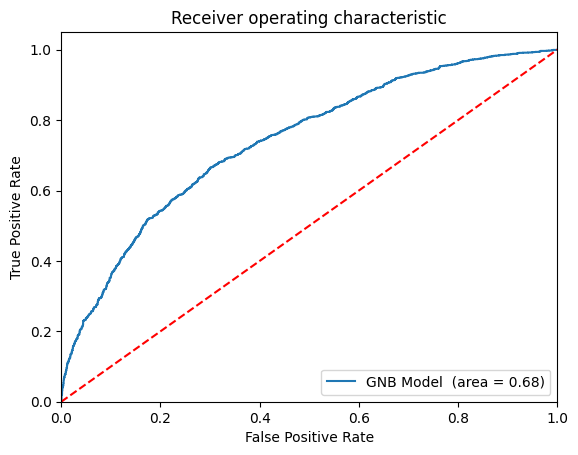

In [5]:
### Gussian Naive Bayes Algorithm
gnb = GaussianNB()
 
 
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
 
print(confusion_matrix(y_test, y_pred_gnb))
 
print(classification_report(y_test, y_pred_gnb))
 
 
### Model Accuracies
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print ("NAIVEBAYES Accuracy : " ,accuracy_gnb)
 
 
gnb_roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
print ("NAIVEBAYES Auc: ", gnb_roc_auc)
 
 
fpr1_gnb, tpr1_gnb, thresholds1_gnb = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
 
### Plot the ROC curves
plt.figure()
plt.plot(fpr1_gnb, tpr1_gnb, label='GNB Model  (area = %0.2f)' % gnb_roc_auc)
 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Stakes distribution in the wrong predictions
True     0.578098
False    0.421902
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


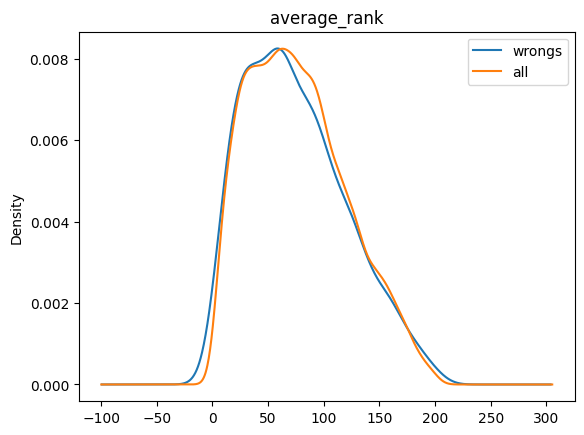

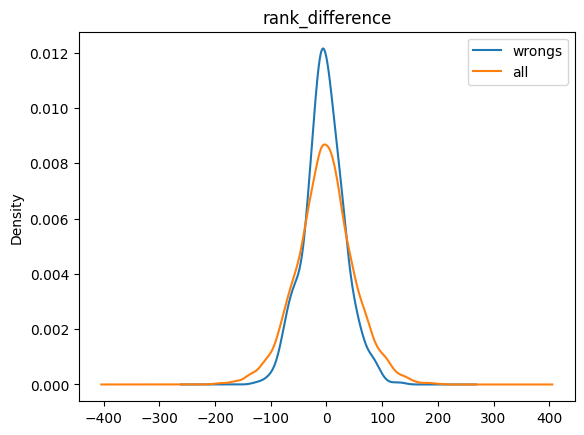

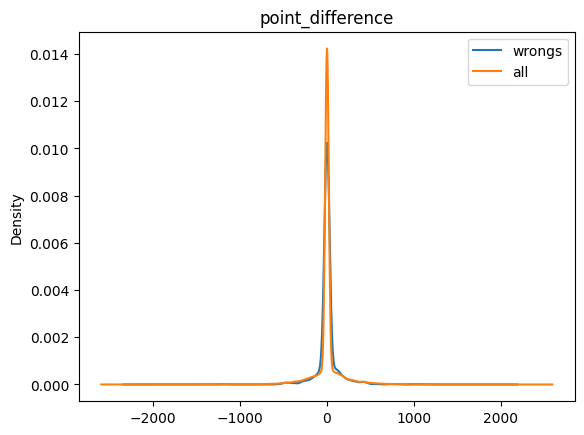

In [6]:
features = ['average_rank', 'rank_difference', 'point_difference']

# Get the wrongly predicted matches
wrongs = y_test != gnb.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [7]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [9]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # get the prediction proability of the home team winning
        home_win_prob = gnb.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group E:___
Brazil vs. Switzerland: Brazil wins with 0.54
Brazil vs. Costa Rica: Brazil wins with 0.69
Brazil vs. Serbia: Brazil wins with 0.77
Switzerland vs. Costa Rica: Switzerland wins with 0.63
Switzerland vs. Serbia: Switzerland wins with 0.72
Costa Rica vs. Serbia: Costa Rica wins with 0.58
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.66
Argentina vs. Croatia: Argentina wins with 0.66
Argentina vs. Nigeria: Argentina wins with 0.83
Iceland vs. Croatia: Croatia wins with 0.54
Iceland vs. Nigeria: Iceland wins with 0.72
Croatia vs. Nigeria: Croatia wins with 0.72
___Starting group A:___
Russia vs. Saudi Arabia: Draw
Russia vs. Egypt: Egypt wins with 0.65
Russia vs. Uruguay: Uruguay wins with 0.94
Saudi Arabia vs. Egypt: Egypt wins with 0.68
Saudi Arabia vs. Uruguay: Uruguay wins with 0.95
Egypt vs. Uruguay: Uruguay wins with 0.90
___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.87
Belgium vs. Tunisia: Belgium wins with 0.69
Belgiu

In [10]:
world_cup

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay,1,0.918517
Saudi Arabia,A,Russia,Uruguay,Egypt,1,0.867666
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.428455
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.785361
Portugal,B,Spain,Morocco,Iran,9,2.167373
Spain,B,Portugal,Iran,Morocco,6,1.958871
Morocco,B,Iran,Portugal,Spain,1,0.918460
Iran,B,Morocco,Spain,Portugal,1,0.955296
France,C,Australia,Peru,Denmark,4,1.622101


In [11]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.785361
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.428455
Spain,B,Portugal,Iran,Morocco,6,1.958871
Portugal,B,Spain,Morocco,Iran,9,2.167373
Denmark,C,Peru,Australia,France,9,2.131432
Peru,C,Denmark,France,Australia,4,1.622871
Croatia,D,Nigeria,Argentina,Iceland,6,1.593100
Argentina,D,Iceland,Croatia,Nigeria,9,2.156828
Brazil,E,Switzerland,Costa Rica,Serbia,9,2.005213


In [13]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = gnb.predict_proba(row)[:,1][0]
        
        # Display resultes
        if gnb.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.59
Denmark vs. Croatia: Denmark wins with probability 0.66
Brazil vs. Mexico: Brazil wins with probability 0.62
Belgium vs. Colombia: Belgium wins with probability 0.69
Egypt vs. Portugal: Portugal wins with probability 0.96
Peru vs. Argentina: Argentina wins with probability 0.64
Switzerland vs. Germany: Germany wins with probability 0.81
England vs. Poland: Poland wins with probability 0.55


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.58
Brazil vs. Belgium: Belgium wins with probability 0.60
Portugal vs. Argentina: Portugal wins with probability 0.52
Germany vs. Poland: Germany wins with probability 0.70


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.64
Portugal vs. Germany: Germany wins with probability 0.71


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.67


